In [21]:
import json
import requests
import pandas as pd
import os

In [58]:
from sec_api import ExtractorApi
ticker = "TSLA"
urls = {}
merged_txt = ""
with open(f'10Kfillings/{ticker}/urls.json', 'r') as file:
    urls = json.load(file)
for year, url in urls.items():
    # 10-K filing URL of ticker
    filing_url = url
    extractorApi = ExtractorApi("bbcee50b49f38b3e91e37c6466aed9a4795ecbda3108aa43abb6b2c1f52acd5d")
    section_text = extractorApi.get_section(filing_url, "1A", "text")
    merged_txt += section_text
with open(f'10Kfillings/TSLA/risk.txt', 'w') as file:
    file.write(merged_txt)

In [63]:
print(section_text)

 ITEM 1A. 

RI SK FACTORS 

##TABLE_END

You should carefully consider the risks described below together with the other information set forth in this report, which could materially affect our business, financial condition and future results. The risks described below are not the only risks facing our company. Risks and uncertainties not currently known to us or that we currently deem to be immaterial also may materially adversely affect our business, financial condition and operating results. 

Risks Related to Our Business and Industry

We have experienced in the past, and may experience in the future, delays or other complications in the design, manufacture, launch, production, delivery and servicing ramp of new vehicles and other products such as Model 3, Model Y, our energy storage products and Solar Roof, which could harm our brand, business, prospects, financial condition and operating results.

We have previously experienced launch, manufacturing, production and delivery ramp d

In [4]:
# get list of  10-k file html for a ticker and save local
def get_url_of_10_k(ticker):
    urls = {}
    from sec_api import QueryApi

    queryApi = QueryApi(api_key="bbcee50b49f38b3e91e37c6466aed9a4795ecbda3108aa43abb6b2c1f52acd5d")
    q = f"ticker:{ticker} AND filedAt:[1995-01-01 TO 2023-12-31] AND formType:\"10-K\""
    
    query = {
      "query": q,
      "from": "0",
      "size": "50",
      "sort": [{ "filedAt": { "order": "desc" } }]
    }
    
    filings = queryApi.get_filings(query)
    for filings in filings["filings"]:

        year = filings["filedAt"][:4]
       
        url =  filings["linkToFilingDetails"]


        if filings["formType"] == "10-K":
         urls[year] = url
    with open(f'10Kfillings/{ticker}/urls.json', 'w') as file:
        json.dump(urls, file)
    

In [134]:
# urls = get_url_of_10_k("TSLA")

In [18]:
# download the 10-k fillings of the ticker
def save_10k_fillings(ticker):
    urls = {}
    with open(f'10Kfillings/{ticker}/urls.json', 'r') as file:
        urls = json.load(file)
    for year, url in urls.items():
        # 10-K filing URL of ticker
        filing_url = url
        
        # XBRL-to-JSON converter API endpoint
        xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"
        
        # get your API key at https://sec-api.io
        api_key = "bbcee50b49f38b3e91e37c6466aed9a4795ecbda3108aa43abb6b2c1f52acd5d"
        
        final_url = xbrl_converter_api_endpoint + "?htm-url=" + filing_url + "&token=" + api_key
        
        # make request to the API
        response = requests.get(final_url)
        
        # load JSON into memory
        xbrl_json = json.loads(response.text)
    
        
        if xbrl_json["status"] == 404:
            continue
        with open(f'10Kfillings/{ticker}/{year}.json', 'w') as file:
            json.dump(xbrl_json, file, indent=4)
        
        # # income statement example
        # print(xbrl_json['StatementsOfIncome'])

In [6]:
# convert XBRL-JSON of income statement to pandas dataframe
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T
    


In [11]:
def save_income_data(ticker):
    with open(f'10Kfillings/{ticker}/2023.json', 'r') as file:
        xbrl_json = json.load(file)
        df = get_income_statement(xbrl_json)
        json_data = df.to_json(orient='records')
        with open('data.json', 'w') as file:
            file.write(json_data)

In [13]:
def merge_income_statements(ticker):
    urls = {}
    with open(f'10Kfillings/{ticker}/urls.json', 'r') as file:
        urls = json.load(file)
    income_statement_list = []
    for year, url in urls.items():
        xbrl_json = {}
        try:
            with open(f'10Kfillings/{ticker}/{year}.json', 'r') as file:
                xbrl_json = json.load(file)
                print(year)
                income_statement_list.append(get_income_statement(xbrl_json))
        except FileNotFoundError:
            continue
                
    print(income_statement_list)

2023
2022
2021
2020
2019


TypeError: string indices must be integers, not 'str'

In [19]:
get_10k_fillings("TSLA")

KeyError: 'status'

In [15]:
def extract_income_statement(ticker):
    urls = {}
    with open(f'10Kfillings/{ticker}/urls.json', 'r') as file:
        urls = json.load(file)
    income_statements = {} 
    for year, url in urls.items():
        try:
            with open(f'10Kfillings/{ticker}/{year}.json', 'r') as file:
                xbrl_json = json.load(file)
            income_statements[year] = xbrl_json["StatementsOfIncome"]
        except FileNotFoundError:
            continue    
    with open(f'10Kfillings/{ticker}/income_statement_merge.txt', 'w') as file:
            json.dump(income_statements, file, indent=4)    

In [192]:
extract_income_statement("TSLA")

In [193]:
# get the data and save local 

In [26]:
from analysis import *

Loaded openai api key.


In [27]:
question = "Here is some income data, help me to generate some formatted data that can be used to draw a chart"
get_answer_from_openai("TSLA", question)

Memorizing...


  0%|                             | 0/2687 [00:00<?, ?it/s]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.


  1%|▏                   | 21/2687 [00:27<57:18,  1.29s/it]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.


  1%|▏                 | 25/2687 [00:59<2:02:24,  2.76s/it]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.


  3%|▋                   | 94/2687 [01:24<20:24,  2.12it/s]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped 

  5%|▊                | 123/2687 [02:33<1:07:49,  1.59s/it]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.


  5%|▉                | 139/2687 [02:58<1:07:27,  1.59s/it]

Skipped an uninformative chunk.
Skipped an uninformative chunk.


  5%|▉                | 142/2687 [03:22<1:32:28,  2.18s/it]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.


  8%|█▍                 | 206/2687 [03:42<22:51,  1.81it/s]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped 

  9%|█▋                 | 236/2687 [03:42<13:20,  3.06it/s]

Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped an uninformative chunk.
Skipped 

 11%|██                 | 288/2687 [03:51<32:06,  1.25it/s]


KeyboardInterrupt: 

In [4]:
get_chart_data("TSLA")

NameError: name 'OpenAI' is not defined

In [12]:
save_income_data("TSLA")

In [24]:
def merge_json_files_to_txt(directory, output_file):
    # Create a list to hold the data from all JSON files
    all_data = []

    # Walk through the directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):  # Check for JSON files
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                all_data.append(data)  # Append the data from each JSON file

    # Write all data to a text file
    with open(output_file, 'w') as file:
        for data in all_data:
            # Convert the dictionary to a string and write to the file
            file.write(json.dumps(data) + '\n')  # Each JSON data on new line

# Usage
directory_path = '10Kfillings/TSLA' 
output_txt_file = '10Kfillings/TSLA/merged_fillings.txt' 
merge_json_files_to_txt(directory_path, output_txt_file)

In [ ]:
def get_income_statement(xbrl_json):
    income_statement_store = {}

    # iterate over each US GAAP item in the income statement
    for usGaapItem in xbrl_json['StatementsOfIncome']:
        values = []
        indicies = []

        for fact in xbrl_json['StatementsOfIncome'][usGaapItem]:
            # only consider items without segment. not required for our analysis.
            if 'segment' not in fact:
                index = fact['period']['startDate'] + '-' + fact['period']['endDate']
                # ensure no index duplicates are created
                if index not in indicies:
                    values.append(fact['value'])
                    indicies.append(index)                    

        income_statement_store[usGaapItem] = pd.Series(values, index=indicies) 

    income_statement = pd.DataFrame(income_statement_store)
    # switch columns and rows so that US GAAP items are rows and each column header represents a date range
    return income_statement.T 

In [43]:
from sec_api import QueryApi
api_key = "bbcee50b49f38b3e91e37c6466aed9a4795ecbda3108aa43abb6b2c1f52acd5d"
# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)

# fetch all 10-Q and 10-K filings for Apple
query = {
    "query": {
        "query_string": {
            "query": "(formType:\"10-Q\" OR formType:\"10-K\") AND ticker:TSLA"
        }
    },
    "from": "0",
    "size": "20",
    "sort": [{ "filedAt": { "order": "desc" } }]
}

query_result = query_api.get_filings(query)

In [44]:
accession_numbers = []

# extract accession numbers of each filing
for filing in query_result['filings']:
    accession_numbers.append(filing['accessionNo']);
    

In [45]:
import time

# get XBRL-JSON for a given accession number
def get_xbrl_json(accession_no, retry = 0):
    request_url = xbrl_converter_api_endpoint + "?accession-no=" + accession_no + "&token=" + api_key

    # linear backoff in case API fails with "too many requests" error
    try:
      response_tmp = requests.get(request_url)
      xbrl_json = json.loads(response_tmp.text)
    except:
      if retry > 5:
        raise Exception('API error')
      
      # wait 500 milliseconds on error and retry
      time.sleep(0.5) 
      return get_xbrl_json(accession_no, retry + 1)

    return xbrl_json

In [46]:
def merge_income_statements(statement_a, statement_b):
    return statement_a.merge(statement_b,
                     how="outer", 
                     on=statement_b.index, 
                     suffixes=('_left', ''))

In [47]:
def clean_income_statement(statement):
    for column in statement:

        # column has more than 5 NaN values
        is_nan_column = statement[column].isna().sum() > 5

        if column.endswith('_left') or column == 'key_0' or is_nan_column:
            statement = statement.drop(column, axis=1)
    
    # rearrange columns so that first column represents first quarter
    # e.g. 2018, 2019, 2020 - and not 2020, 2019, 2018
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [53]:
from IPython.display import display, HTML
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"
previous_income_statement_set = False
income_statement_final = None

for accession_no in accession_numbers[0:9]:
# for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
    print(accession_no)
    
    # get XBRL-JSON of 10-Q or 10-K filing by accession number
    xbrl_json_data = get_xbrl_json(accession_no)
    
    # convert XBRL-JSON to a pandas dataframe
    income_statement_uncleaned = get_income_statement(xbrl_json_data)

    # clean the income statement
    income_statement_cleaned = clean_income_statement(income_statement_uncleaned)
    
    # print income statement on each iteration to monitor progress
    display(HTML(income_statement_cleaned.to_html()))
    
    # merge new income statement with previously generated income statement
    if previous_income_statement_set:
        income_statement_final = clean_income_statement(merge_income_statements(income_statement_final, income_statement_cleaned))
    else:
        income_statement_final = income_statement_cleaned
        previous_income_statement_set = True

0001628280-24-017503


,2023-01-01-2023-03-31,2024-01-01-2024-03-31
RevenueFromContractWithCustomerExcludingAssessedTax,23329000000,21301000000
CostOfRevenue,18818000000,17605000000
GrossProfit,4511000000,3696000000
ResearchAndDevelopmentExpense,771000000,1151000000
SellingGeneralAndAdministrativeExpense,1076000000,1374000000
OperatingExpenses,1847000000,2525000000
OperatingIncomeLoss,2664000000,1171000000
InvestmentIncomeInterest,213000000,350000000
InterestExpense,29000000,76000000
OtherNonoperatingIncomeExpense,-48000000,108000000


0001628280-24-002390


,2021-01-01-2021-12-31,2022-01-01-2022-12-31,2023-01-01-2023-12-31
RevenueFromContractWithCustomerExcludingAssessedTax,53823000000,81462000000,96773000000
CostOfRevenue,40217000000,60609000000,79113000000
GrossProfit,13606000000,20853000000,17660000000
ResearchAndDevelopmentExpense,2593000000,3075000000,3969000000
SellingGeneralAndAdministrativeExpense,4517000000,3946000000,4800000000
RestructuringAndOtherExpenses,-27000000,176000000,0
OperatingExpenses,7083000000,7197000000,8769000000
OperatingIncomeLoss,6523000000,13656000000,8891000000
InvestmentIncomeInterest,56000000,297000000,1066000000
InterestExpense,371000000,191000000,156000000


KeyError: array(['RevenueFromContractWithCustomerExcludingAssessedTax',
       'CostOfRevenue', 'GrossProfit', 'ResearchAndDevelopmentExpense',
       'SellingGeneralAndAdministrativeExpense',
       'RestructuringAndOtherExpenses', 'OperatingExpenses',
       'OperatingIncomeLoss', 'InvestmentIncomeInterest',
       'InterestExpense', 'OtherNonoperatingIncomeExpense',
       'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
       'IncomeTaxExpenseBenefit', 'ProfitLoss',
       'NetIncomeLossAttributableToNoncontrollingInterest',
       'NetIncomeLoss', 'EarningsPerShareBasic',
       'EarningsPerShareDiluted',
       'WeightedAverageNumberOfSharesOutstandingBasic',
       'WeightedAverageNumberOfDilutedSharesOutstanding'], dtype=object)

In [54]:
from datetime import datetime

# convert string to int or float
def num(string):
    try:
        return int(string)
    except ValueError:
        return float(string)
    
# calculate 4th quarter results
# 4th quarter results are not reported seperately and have to be calculated using yearly and 9-month results
def add_fourth_quarter_results(statement):
    for column in statement:

        # ['2018', '09', '30', '2019', '09', '28']
        date_strings = [a for a in column.split('-')] 

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')

        delta = d1 - d0

        # is annual results column
        if delta.days > 350:
            for column_1 in statement:
                date_strings_1 = [a for a in column_1.split('-')]

                d1_0 = datetime.strptime(date_strings_1[0] + date_strings_1[1] + date_strings_1[2], '%Y%m%d')
                d1_1 = datetime.strptime(date_strings_1[3] + date_strings_1[4] + date_strings_1[5], '%Y%m%d')

                delta_1 = d1_1 - d1_0

                # same starting month and 9-month results
                # calculate 4th quarter
                if d1_0 == d0 and delta_1.days > 200 and delta_1.days < 350:
                    fourth_quarter_column_name = column_1[11:] + column[10:]

                    fourth_quarter_values = []

                    for row_key, row_value in statement[column].iteritems():
                        value = num(statement[column][row_key]) - num(statement[column_1][row_key])
                        
                        if isinstance(value, float):
                            value = round(value, 2)
            
                        fourth_quarter_values.append(str(value))

                    statement[fourth_quarter_column_name] = fourth_quarter_values
 
                    # Calculate correct values of
                    # WeightedAverageNumberOfSharesOutstandingBasic = use value of annual result
                    # WeightedAverageNumberOfDilutedSharesOutstanding = use value of annual result
                    # EarningsPerShareBasic = NetIncomeLoss / WeightedAverageNumberOfSharesOutstandingBasic
                    # EarningsPerShareDiluted = NetIncomeLoss / WeightedAverageNumberOfDilutedSharesOutstanding
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"] = statement[column]["WeightedAverageNumberOfSharesOutstandingBasic"]
                    statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"] = statement[column]["WeightedAverageNumberOfDilutedSharesOutstanding"]

                    statement[fourth_quarter_column_name]["EarningsPerShareBasic"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfSharesOutstandingBasic"]), 2)
                    
                    statement[fourth_quarter_column_name]["EarningsPerShareDiluted"] = round(num(statement[fourth_quarter_column_name]["NetIncomeLoss"]) / 
                                                                                         num(statement[fourth_quarter_column_name]["WeightedAverageNumberOfDilutedSharesOutstanding"]), 2)
                
    # sort columns
    sorted_columns = sorted(statement.columns.values)
    
    return statement[sorted_columns]

In [55]:
# remove all non-quarterly columns
def only_quarterly_results(statement):
    for column in statement:
        # convert all strings to int
        date_strings = [a for a in column.split('-')]

        d0 = datetime.strptime(date_strings[0] + date_strings[1] + date_strings[2], '%Y%m%d')
        d1 = datetime.strptime(date_strings[3] + date_strings[4] + date_strings[5], '%Y%m%d')
        delta = d1 - d0

        # column represents more timeframe longer than one quarter
        if delta.days > 100:
            statement = statement.drop(column, axis=1)
    return statement

NameError: name 'qrt_income_statement' is not defined

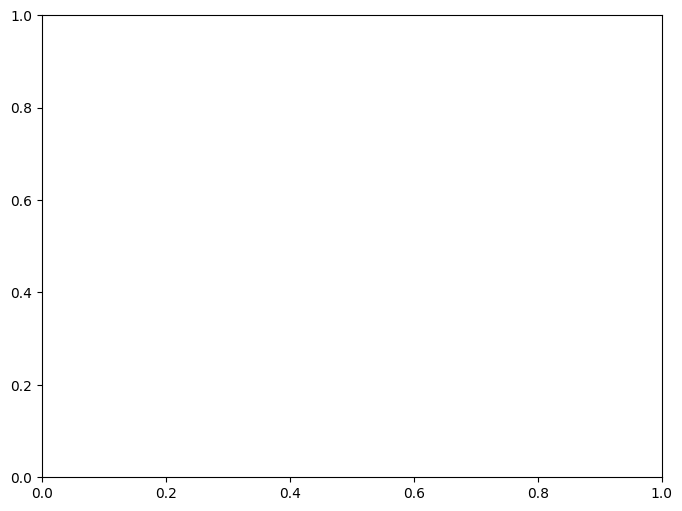

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()